In [44]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
# from src.gaussian import Gaussian
# from src.mix_gaussian import MixedGaussian
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [45]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [46]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=16, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")

parser.add_argument("--n_epoch", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=4, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [47]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [48]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [49]:
def GT(x, y):
    mi = -0.5 * np.log(1 - opt.rho**2) * opt.d
    c = opt.rho / (2 * (1 - opt.rho**2))
    return mi + c * (2 * x * y - opt.rho *(x**2 + y**2)).sum(dim=1)


def GT_prob(x, y):
    """
    return the probability P(1|X,Y)
    """
    return GT(x, y).exp() / (1+ GT(x, y).exp())

In [50]:
name = f'./results/Smoothed_InfoNCE_GT_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/Smoothed_InfoNCE_GT_dim{opt.d}_reg/{TIMESTAMP}')

discriminator = Net(input_size=opt.d*2, hidden_size=100)

In [51]:
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [52]:
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [53]:
def plot_subfigure(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    The inputs should be X and Y, which are the coordinates of the points.

    net should be a neural network with Tensor inputs.
    """

    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.cat((torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ),dim=-1)).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()

    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    # ax.figure.colorbar(im)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")
    return im


def plot_fig(net, d=6):
    f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
    for i in range(d):
        for j in range(d):
            im = plot_subfigure(net, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
    f.colorbar(im, ax=axs.ravel().tolist())
    return f

In [54]:
import torch
a = torch.Tensor([[1, 2], [3, 4]])
b = torch.Tensor([[5, 6], [7, 8]])

In [55]:
x_tile = a.unsqueeze(0).repeat((a.shape[0], 1, 1))
y_tile = b.unsqueeze(1).repeat((1, b.shape[0], 1))
train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, a.shape[1]+b.shape[1])
train_label = torch.eye(a.shape[0]).reshape(-1,)

In [56]:
train_data, train_data[train_label==0], train_data[train_label==1]

(tensor([[1., 2., 5., 6.],
         [3., 4., 5., 6.],
         [1., 2., 7., 8.],
         [3., 4., 7., 8.]]),
 tensor([[3., 4., 5., 6.],
         [1., 2., 7., 8.]]),
 tensor([[1., 2., 5., 6.],
         [3., 4., 7., 8.]]))

In [57]:
def smooth_loss(net, model, x_data, y_data, writer=None, epoch=None, reg=False):
    # alpha: float p(C=0)/p(C=1)
    # net: torch.nn.Module
    # model: sklearn.tree.DecisionTreeClassifier
    # return: loss of smoothed infoNCE
    # first term:
    # E[f(X,Y)*p(C=1|X,Y)] + alpha*E[f(X',Y')*p(C=1|X',Y')]
    joint_samples = torch.cat((x_data, y_data), dim=1)
    x_tile = x_data.unsqueeze(0).repeat((x_data.shape[0], 1, 1))
    y_tile = y_data.unsqueeze(1).repeat((1, x_data.shape[0], 1))
    train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, x_data.shape[1]+y_data.shape[1])
    train_label = torch.eye(x_data.shape[0]).reshape(-1,)
   
    marginal_samples = train_data[train_label==0,:]
    prob_DT = model(train_data[:,:opt.d], train_data[:,opt.d:]).reshape(-1,1)
    pos_prob_DT = torch.Tensor(prob_DT)[train_label==1,:]
    neg_prob_DT = torch.Tensor(prob_DT)[train_label==0,:]
    # idx_X = torch.randperm(x_data.shape[0])
    # idx_Y = torch.randperm(y_data.shape[0])
    # marginal_samples = torch.cat((x_data[idx_X], y_data[idx_Y]), dim=1)
    # pos_prob_DT = torch.Tensor(model.predict_proba(joint_samples.cpu().numpy())[:,1].reshape(-1,1))
    # neg_prob_DT = torch.Tensor(model.predict_proba(marginal_samples.cpu().numpy())[:,1].reshape(-1,1))
    a = (net(joint_samples)*pos_prob_DT).mean() + (net(marginal_samples)*neg_prob_DT).mean()
    # second term:
    # E[log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X])]

    # b_list contains log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X]) for each x
    b_list = []
    for i in range(x_data.shape[0]):
        x_i = x_data[i,:]
        y_i = y_data[i,:]
        batch_label = torch.zeros(x_data.shape[0])
        batch_label[i] = 1
        x_tile = x_i.unsqueeze(0).repeat((x_data.shape[0], 1))
        batch_xy = torch.cat([x_tile, y_data], dim = 1)

        batch_xy_ = torch.cat((batch_xy[batch_label==1].repeat((batch_xy.shape[0]-1, 1)), batch_xy[batch_label==0]), dim=0)

        # P(C=0|x) = E[P(C=0|x,Y')]
        pcx = (1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).mean()

        # b_list.append(torch.log(net(batch_xy[batch_label==1]).exp()* torch.Tensor(model.predict_proba(batch_xy[batch_label==1].cpu().numpy().reshape(1, -1))[:,0])*0.5/pcx + (net(batch_xy[batch_label==0]).exp()*torch.Tensor(model.predict_proba(batch_xy[batch_label==0].cpu().numpy())[:,0].reshape(-1,1))*0.5/pcx).mean()))


        b_list.append(torch.logsumexp(net(batch_xy_)+torch.log((1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).reshape(-1,1)), dim=0) - np.log(batch_xy_.shape[0]) - torch.log(pcx))
    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', torch.mean(torch.stack(b_list)), epoch)

    if reg:
        return a - sum(b_list)/len(b_list) - (sum(b_list)/len(b_list))**2
    else:
        return a - sum(b_list)/len(b_list)

In [58]:
def smooth_loss2(net, model, x_data, y_data, writer=None, epoch=None):
    # alpha: float p(C=0)/p(C=1)
    # net: torch.nn.Module
    # model: sklearn.tree.DecisionTreeClassifier
    # return: loss of smoothed infoNCE
    # first term: 
    # E[f(X,Y)*p(C=1|X,Y)] + alpha*E[f(X',Y')*p(C=1|X',Y')]
    joint_samples = torch.cat((x_data, y_data), dim=1)
    x_tile = x_data.unsqueeze(0).repeat((x_data.shape[0], 1, 1))
    y_tile = y_data.unsqueeze(1).repeat((1, x_data.shape[0], 1))
    train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, x_data.shape[1]+y_data.shape[1])
    train_label = torch.eye(x_data.shape[0]).reshape(-1,)
   
    marginal_samples = train_data[train_label==0,:]
    prob_DT = model(train_data[:,:opt.d], train_data[:,opt.d:]).reshape(-1,1)
    pos_prob_DT = torch.Tensor(prob_DT)[train_label==1,:]

    neg_prob_DT = torch.Tensor(prob_DT)
    # idx_X = torch.randperm(x_data.shape[0])
    # idx_Y = torch.randperm(y_data.shape[0])
    # marginal_samples = torch.cat((x_data[idx_X], y_data[idx_Y]), dim=1)
    # pos_prob_DT = torch.Tensor(model.predict_proba(joint_samples.cpu().numpy())[:,1].reshape(-1,1))
    # neg_prob_DT = torch.Tensor(model.predict_proba(marginal_samples.cpu().numpy())[:,1].reshape(-1,1))
    a = (net(joint_samples)*pos_prob_DT).mean() + (net(train_data)*neg_prob_DT).mean()
    # second term:
    # E[log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X])]

    # b_list contains log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X]) for each x
    b_list = []
    for i in range(x_data.shape[0]):
        x_i = x_data[i,:]
        y_i = y_data[i,:]
        batch_label = torch.zeros(x_data.shape[0])
        batch_label[i] = 1
        x_tile = x_i.unsqueeze(0).repeat((x_data.shape[0], 1))
        batch_xy = torch.cat([x_tile, y_data], dim = 1)

        batch_xy_ = torch.cat((batch_xy[batch_label==1].repeat((batch_xy.shape[0], 1)), batch_xy), dim=0)

        # P(C=0|x) = E[P(C=0|x,Y')]
        pcx = (1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).mean()

        # b_list.append(torch.log(net(batch_xy[batch_label==1]).exp()* torch.Tensor(model.predict_proba(batch_xy[batch_label==1].cpu().numpy().reshape(1, -1))[:,0])*0.5/pcx + (net(batch_xy[batch_label==0]).exp()*torch.Tensor(model.predict_proba(batch_xy[batch_label==0].cpu().numpy())[:,0].reshape(-1,1))*0.5/pcx).mean()))

        
        b_list.append(torch.logsumexp(net(batch_xy_)+torch.log((1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).reshape(-1,1)), dim=0) - np.log(batch_xy_.shape[0]) - torch.log(pcx))
    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', torch.mean(torch.stack(b_list)), epoch)
    return a - sum(b_list)/len(b_list)

In [59]:
# continue_train = False  # set to True to continue to train
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)
        idx_X, idx_Y = randerange(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]
 
            optimizer_D.zero_grad()
            loss = - smooth_loss(discriminator, GT_prob, batch_X, batch_Y, reg=True) # negative infonce_bound as the loss
            # print(loss)
            loss.backward()

            optimizer_D.step()


        with torch.no_grad():
            mi_est = smooth_loss(discriminator, GT_prob, X, Y, writer, _iter)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), _iter)
        writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%200==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(discriminator, opt.d)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, _iter)

writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 200, loss: -7.139431, mi_est: 6.994064


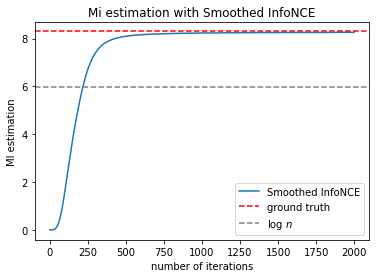

In [ ]:
plt.plot(mi_list, label='Smoothed InfoNCE')

plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('Mi estimation with Smoothed InfoNCE')
plt.legend()
plt.savefig(f'results/Smoothed_InfoNCE_dim{opt.d}_ma{ma_rate}.pdf')

In [ ]:
for name, parms in discriminator.named_parameters():	
    print('name:', name, 'grad_requirs:',parms.requires_grad, \
        'grad_value:',parms.grad)

name: fc.0.weight grad_requirs: True grad_value: tensor([[-0.0229, -0.0466,  0.0383,  ...,  0.0614, -0.0894,  0.2198],
        [-0.0187, -0.0705,  0.0187,  ...,  0.0983, -0.0680,  0.2208],
        [-0.0122,  0.0087, -0.0422,  ..., -0.0748,  0.0662, -0.1534],
        ...,
        [-0.0170,  0.0048, -0.0548,  ..., -0.0825,  0.0259, -0.1222],
        [-0.0281, -0.0758, -0.0026,  ...,  0.1041, -0.0782,  0.2238],
        [-0.0595, -0.0597,  0.0132,  ...,  0.0880, -0.1293,  0.2469]])
name: fc.0.bias grad_requirs: True grad_value: tensor([-0.9224, -0.8778,  0.4744,  0.4234, -0.9043, -1.0166,  0.4298,  0.5655,
         0.4693, -1.0354, -0.9200, -0.9050, -0.9638,  0.4456,  0.3871,  0.3872,
         0.4935, -0.9590,  0.4722,  0.3059, -0.9603,  0.4551,  0.4682, -1.0840,
        -0.9464,  0.4685, -0.8971,  0.4639, -0.9704,  0.4970, -0.9251,  0.4193,
         0.3681,  0.5213,  0.4121,  0.4627, -0.9003, -0.9268, -0.9814, -0.8268,
         0.5375, -0.9621,  0.4744, -0.8080, -1.0938, -0.9321,  0.4058,